<a href="https://colab.research.google.com/github/amilkh/cs230-fer/blob/transfer-learning/fer2013_using_all_train_sets_zip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 1.x
!pip install keras-vggface
!pip install scikit-image
!pip install pydot

In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.python.lib.io import file_io

%matplotlib inline

import keras
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras_vggface.vggface import VGGFace
from keras.utils import plot_model
from sklearn.metrics import *
from keras.engine import Model
from keras.layers import Input, Flatten, Dense, Activation, Conv2D, MaxPool2D, BatchNormalization, Dropout, MaxPooling2D
import skimage
from skimage.transform import rescale, resize

import pydot

In [0]:
EPOCHS = 20
BS = 128
DROPOUT_RATE = 0.5
FROZEN_LAYER_NUM = 101

ADAM_LEARNING_RATE = 0.001
SGD_LEARNING_RATE = 0.01
SGD_DECAY = 0.0001

Resize_pixelsize = 197

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
! rm -rf train
! mkdir train
! unzip -q '/content/drive/My Drive/cs230 project/dataset/emotion.zip' -d train
! unzip -q '/content/drive/My Drive/cs230 project/dataset/googleset.zip' -d train
! unzip -q '/content/drive/My Drive/cs230 project/dataset/fer2013/train.zip' -d train

In [0]:
! rm -rf dev test
! mkdir dev test
! unzip -q '/content/drive/My Drive/cs230 project/dataset/fer2013/test-public.zip' -d dev
! unzip -q '/content/drive/My Drive/cs230 project/dataset/fer2013/test-private.zip' -d test

In [35]:
%%bash
root='/content/train/'
IFS=$(echo -en "\n\b")
(for dir in $(ls -1 "$root")
    do printf "$dir: " && ls -i "$root$dir" | wc -l
 done)

0 angry: 4083
1 disgust: 552
2 fear: 4181
3 happy: 7326
4 sad: 4925
5 surprise: 3272
6 neutral: 5055


In [0]:
def get_datagen(dataset):
    # Generate batches of tensor image data with real-time data augmentation. The data will be looped over (in batches) indefinitely
    # rescale:          Rescaling factor (defaults to None). Multiply the data by the value provided (before applying any other transformation)
    # rotation_range:   Int. Degree range for random rotations
    # shear_range:      Float. Shear Intensity (Shear angle in counter-clockwise direction as radians)
    # zoom_range:       Float or [lower, upper]. Range for random zoom. If a float, [lower, upper] = [1-zoom_range, 1+zoom_range]
    # fill_mode :       Points outside the boundaries of the input are filled according to the given mode: {"constant", "nearest", "reflect" or "wrap"}
    # horizontal_flip:  Boolean. Randomly flip inputs horizontally
    datagen = ImageDataGenerator(
                        rescale=1./255,
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=0.1,
                        horizontal_flip=True)

    return datagen.flow_from_directory(
            dataset,
            target_size=(197, 197),
            color_mode='rgb',
            shuffle = True,
            class_mode='categorical',
            batch_size=BS)

In [41]:
from skimage import io, transform

# Load dev/test sets
X_dev_gen   = get_datagen('/content/dev')
X_test_gen = get_datagen('/content/test')

X_dev = np.zeros((len(X_dev_gen.filepaths), 197, 197, 3))
Y_dev = np.zeros((len(X_dev_gen.filepaths), 7))
for i in range(0,len(X_dev_gen.filepaths)):
  x = imread(X_dev_gen.filepaths[i])
  X_dev[i,:] = transform.resize(x, (197,197,3))
  Y_dev[i,X_dev_gen.classes[i]] = 1

X_test = np.zeros((len(X_test_gen.filepaths), 197, 197, 3))
Y_test = np.zeros((len(X_test_gen.filepaths), 7))
for i in range(0,len(X_test_gen.filepaths)):
  x = imread(X_test_gen.filepaths[i])
  X_test[i,:] = transform.resize(x, (197,197,3))
  Y_test[i,X_test_gen.classes[i]] = 1

Found 3589 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


In [0]:
vgg_notop = VGGFace(model='resnet50', include_top=False, input_shape=(Resize_pixelsize, Resize_pixelsize, 3), pooling='avg')
last_layer = vgg_notop.get_layer('avg_pool').output
x = Flatten(name='flatten')(last_layer)
x = Dropout(DROPOUT_RATE)(x)
x = Dense(4096, activation='relu', name='fc6')(x)
x = Dropout(DROPOUT_RATE)(x)
x = Dense(1024, activation='relu', name='fc7')(x)
x = Dropout(DROPOUT_RATE)(x)
# l=0
# for layer in vgg_notop.layers:
#     print(layer,"["+str(l)+"]")
#     l=l+1
    
batch_norm_indices = [2, 6, 9, 13, 14, 18, 21, 24, 28, 31, 34, 38, 41, 45, 46, 53, 56, 60, 63, 66, 70, 73, 76, 80, 83, 87, 88, 92, 95, 98, 102, 105, 108, 112, 115, 118, 122, 125, 128, 132, 135, 138, 142, 145, 149, 150, 154, 157, 160, 164, 167, 170]
for i in range(FROZEN_LAYER_NUM):
    if i not in batch_norm_indices:
        vgg_notop.layers[i].trainable = False
# print('vgg layer 2 is trainable: ' + str(vgg_notop.layers[2].trainable))
# print('vgg layer 3 is trainable: ' + str(vgg_notop.layers[3].trainable))

out = Dense(7, activation='softmax', name='classifier')(x)

model = Model(vgg_notop.input, out)


optim = keras.optimizers.Adam(lr=ADAM_LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
#optim = keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
sgd = keras.optimizers.SGD(lr=SGD_LEARNING_RATE, momentum=0.9, decay=SGD_DECAY, nesterov=True)
rlrop = keras.callbacks.ReduceLROnPlateau(monitor='val_acc',mode='max',factor=0.5, patience=10, min_lr=0.00001, verbose=1)

model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
# plot_model(model, to_file='model2.png', show_shapes=True)

In [0]:
X_train_gen   = get_datagen('/content/train')

history = model.fit_generator(
    generator = X_train_gen,
    steps_per_epoch=len(X_train_gen.filenames) // BS,  # you might want to delete this
    validation_data = (X_dev, Y_dev), 
    shuffle=True,
    epochs=EPOCHS,
    callbacks=[rlrop],
    use_multiprocessing=True,
) 

Found 29394 images belonging to 7 classes.
Epoch 1/20
139/229 [=================>............] - ETA: 1:50 - loss: 1.7627 - acc: 0.3707

In [0]:
print('\n# Evaluate on dev data')
results_dev = model.evaluate_generator(dev_generator, 3509 // BS)
print('dev loss, dev acc:', results_dev)


# Evaluate on dev data
dev loss, dev acc: [0.05221803914065714, 0.9913194444444444]


In [0]:
print('\n# Evaluate on test data')
results_test = model.evaluate_generator(test_generator, 3509 // BS)
print('test loss, test acc:', results_test)


# Evaluate on test data
test loss, test acc: [0.05221803914065714, 0.9913194444444444]


dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


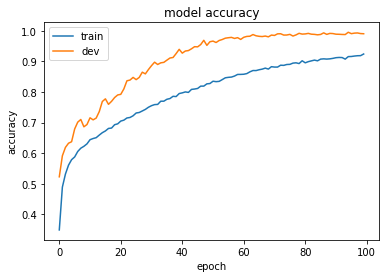

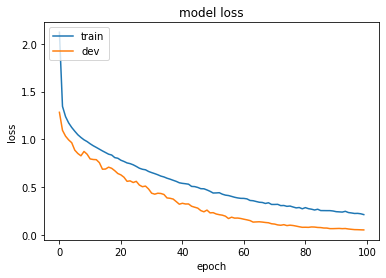

In [0]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

In [0]:
lr_str = '-SGD_LR_%.5f' % SGD_LEARNING_RATE
epoch_str = '-EPOCHS_' + str(EPOCHS)
bs_str = '-BS_' + str(BS)
dropout_str = '-DROPOUT_' + str(DROPOUT_RATE)
test_acc = 'test_acc_%.3f' % results_test[1]
model.save('/content/drive/My Drive/cs230 project/models/tl/tl' + lr_str + epoch_str + bs_str + dropout_str + test_acc + '.h5')

In [0]:
def get_data_for_test(dataset, pixelsize = Resize_pixelsize):
    file_stream = file_io.FileIO(dataset, mode='r')
    data = pd.read_csv(file_stream)
    data[' pixels'] = data[' pixels'].apply(lambda x: [int(pixel) for pixel in x.split()])

    X, Y = data[' pixels'].tolist(), data['emotion'].values
    X = np.array(X, dtype='float32').reshape(-1,48,48,1)
    X = X/255.0
    X_res = np.zeros((X.shape[0], pixelsize,pixelsize,3))
    for ind in range(X.shape[0]):  #X_dev.shape[0]
        sample = X[ind]
        sample = sample.reshape(48, 48)
        image_resized = resize(sample, (pixelsize, pixelsize), anti_aliasing=True)
        X_res[ind,:,:,:] = image_resized.reshape(pixelsize,pixelsize,1)

    Y_res = np.zeros((Y.size, Y.max()+1))
    Y_res[np.arange(Y.size),Y] = 1
    
    return  X_res, Y_res

In [0]:
test_dataset_dir = '/content/drive/My Drive/cs230 project/collab/fer2013/test.csv'
X_test_res, Y_test_res  = get_data_for_test(test_dataset_dir)

In [0]:
model.evaluate(X_test_res, Y_test_res)


3589/3589 [==============================] - 8s 2ms/step


[0.9163703456932072, 0.732237392047814]

In [0]:
from sklearn.metrics import accuracy_score

# configure image data augmentation
tta_aug = ImageDataGenerator(
    # rotation_range  = 10,
    # shear_range     = 10, # 10 degrees
    # zoom_range      = 0.1,
    # fill_mode       = 'reflect',
    horizontal_flip = True
)

# make a prediction using test-time augmentation
def tta_prediction(model, image, n_examples):
	# convert image into dataset
	samples = np.expand_dims(image, 0)
  test_generator = get_data(test_dataset_dir, bs=BS, aug=tta_aug)
	it = test_generator.flow(samples, batch_size=n_examples)
	yhats = model.predict_generator(it, steps=n_examples, verbose=0)
	# sum across predictions
	summed = np.sum(yhats, axis=0)
	# argmax across classes
	return np.argmax(summed)
 
 # evaluate a model on a dataset using test-time augmentation
def tta_evaluate_model(model, testX, testY):
	# configure image data augmentation
	datagen = ImageDataGenerator(horizontal_flip=True)
	# define the number of augmented images to generate per test set image
	n_examples_per_image = 7
	yhats = list()
	for i in range(len(testX)):
		# make augmented prediction
		yhat = tta_prediction(datagen, model, testX[i], n_examples_per_image)
		# store for evaluation
		yhats.append(yhat)
	# calculate accuracy
	testY_labels = np.argmax(testY, axis=1)
	acc = accuracy_score(testY_labels, yhats)
	return acc

In [0]:
print('\n# Evaluate on test data')
TTA_results_test = tta_evaluate_model(model, X_test, Y_test)
print('test loss, test acc:', results_test)
print('TTA test acc:', TTA_results_test)